<a href="https://colab.research.google.com/github/JohnYCLam/MachineLearning/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Functions

In [1]:
!pip install torchmetrics torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 22.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer

import itertools
import math

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import torchmetrics
import torchinfo

from torch.utils.data import Dataset, DataLoader

In [3]:
def generate_time_series(n_steps = 120, trend_min = 1.0, trend_max = 5.0, trend_noise_scale = 0.05, num_cycles = 0, season_noise_scale = 0.):

    trend = np.linspace(trend_min, trend_max, n_steps) + trend_noise_scale * np.random.randn(n_steps)
    trend = trend.astype(np.float32)
    if num_cycles == 0:
        seasonality = 0
    else:
        seasonality = np.sin(np.linspace(0, n_steps, n_steps) * 2 * np.pi / (n_steps / num_cycles)) + season_noise_scale * np.random.randn(n_steps)
        seasonality = seasonality.astype(np.float32)
    total = trend + seasonality

    return {"trend": trend, "seasonality": seasonality, "total": total}

In [4]:
def plot_time_series(time_series):
    fig, ax = plt.subplots(1, 3, figsize = (10, 3))
    ax[0].plot(time_series["trend"])
    ax[0].set_title("Trend")
    ax[1].plot(time_series["seasonality"])
    ax[1].set_title("Seasonality")
    ax[2].plot(time_series["total"])
    ax[2].set_title("Time Series")
    fig.tight_layout()
    plt.show()

In [31]:
class TimeSeriesDataset(Dataset):
    def __init__(self, seq, window = 12, differencing = False, scaler = None):
        self.seq = seq.copy()
        self.window = window
        self.inputs = []
        self.labels = []

        if scaler is not None:
            self.scaler = scaler
            self.seq = (self.scaler.fit_transform(self.seq.reshape(-1, 1))).reshape(-1)
        else:
            self.scaler = None

        if differencing:
            diff = self.seq[1:] - self.seq[: -1]
            for t in range(len(diff) - window):
                input = diff[t: t + window]
                self.inputs.append(input)
                label = diff[t + window]
                self.labels.append(label)
        else:
            for t in range(len(self.seq) - window):
                input = self.seq[t: t + window]
                self.inputs.append(input)
                label = self.seq[t + window]
                self.labels.append(label)

        self.inputs = np.array(self.inputs).reshape(-1, window, 1)
        self.labels = np.array(self.labels).reshape(-1, 1)
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

In [8]:
class SimpleRNN(nn.Module):
    def __init__(self, device, hidden_size = 30, activation = "relu"):
        super().__init__()
        self.rnn = nn.RNN(1, hidden_size = hidden_size, nonlinearity = activation, batch_first = True)
        self.linear = nn.Linear(in_features = hidden_size, out_features = 1)

        self.to(device)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.linear(x[:, -1, :])
        return x

In [9]:
class SimpleLSTM(nn.Module):
    def __init__(self, device, hidden_size = 30, activation = "relu"):
        super().__init__()
        self.rnn = nn.LSTM(1, hidden_size = hidden_size, batch_first = True)
        self.linear = nn.Linear(in_features = hidden_size, out_features = 1)

        self.to(device)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.linear(x[:, -1, :])
        return x

In [10]:
def train_epoch(model, train_loader, loss_func, optimizer, device, clip_norm):
    epoch_loss = torchmetrics.MeanMetric().to(device)
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        if clip_norm:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss(loss)

    return epoch_loss.compute()

In [11]:
def train_model(model, train_loader, loss_func, optimizer, device, num_epochs = 100, clip_norm = False):
    train_epoch_losses = []
    for epoch in tqdm(range(num_epochs), total=num_epochs, desc='Epochs'):
        train_epoch_loss = train_epoch(model, train_loader, loss_func, optimizer, device, clip_norm)
        train_epoch_losses.append(train_epoch_loss)
        if (epoch +1) % 10 == 0:
            print("Epoch: {}. Train loss: {:.3f}".format(epoch + 1, train_epoch_loss))

    return train_epoch_losses

In [55]:
def forecast(model, input, time_series, forecast_step, differencing = False):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        last_train = input.__getitem__(-1)[0]
        input_seq = last_train.reshape(1, -1, 1)  # Last sequence
        input_tensor = torch.from_numpy(input_seq)
        preds = []

        for _ in range(forecast_step):
            output = model(input_tensor)
            scaler = input.scaler
            if scaler is not None:
                pred = float((scaler.inverse_transform(output.cpu().numpy()))[0, 0])
            else:
                pred = output.item()
            preds.append(pred)
            input_tensor = torch.cat((input_tensor[:, 1:, :], output.reshape(1, 1, 1)), dim = 1)

    if differencing:
        preds_original = [input.seq[-1].item()]
        for pred in preds:
            preds_next = preds_original[-1] + pred
            preds_original.append(preds_next)
        preds = preds_original[1:]
    # Plot the results
    plt.figure(figsize=(10, 6))
    print(time_series['total'])
    print(preds)
    plt.plot(range(len(time_series['total'])), time_series['total'], label='Original Data', color='blue')
    plt.plot(range(len(time_series['total']), len(time_series['total']) + len(preds)), preds, label='Forecast', color='red')
    plt.legend()
    plt.show()

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Perfect Linear Trend

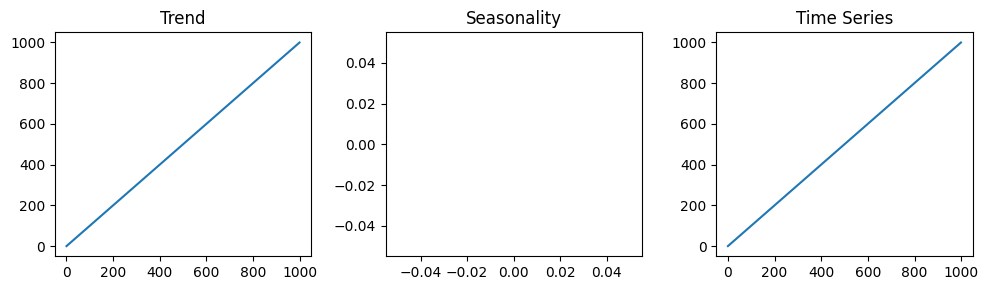

In [95]:
time_series = generate_time_series(n_steps = 1000, trend_min = 0.0, trend_max = 999.0, trend_noise_scale = 0., num_cycles = 0)
plot_time_series(time_series)

In [101]:
window = 10
scaler = None
differencing = True

train_dataset = TimeSeriesDataset(time_series['total'], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [102]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")

In [103]:
torchinfo.summary(model, (window, 1), batch_dim = 0)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleRNN                                [1, 1]                    --
├─RNN: 1-1                               [1, 10, 6]                54
├─Linear: 1-2                            [1, 1]                    7
Total params: 61
Trainable params: 61
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [104]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 0.000
Epoch: 20. Train loss: 0.000
Epoch: 30. Train loss: 0.000
Epoch: 40. Train loss: 0.000
Epoch: 50. Train loss: 0.000
Epoch: 60. Train loss: 0.000
Epoch: 70. Train loss: 0.000
Epoch: 80. Train loss: 0.000
Epoch: 90. Train loss: 0.000
Epoch: 100. Train loss: 0.000


[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

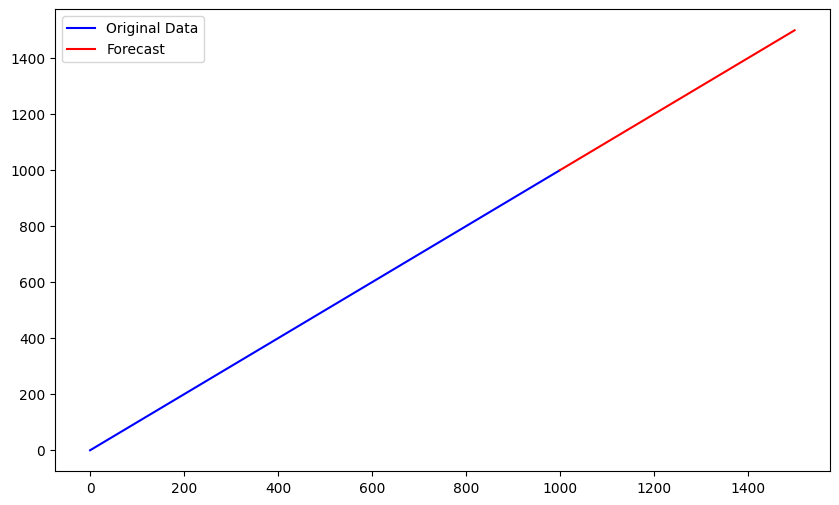

In [105]:
forecast(model, train_dataset, time_series, forecast_step = 500, differencing = differencing)

# Linear Trend with Noise

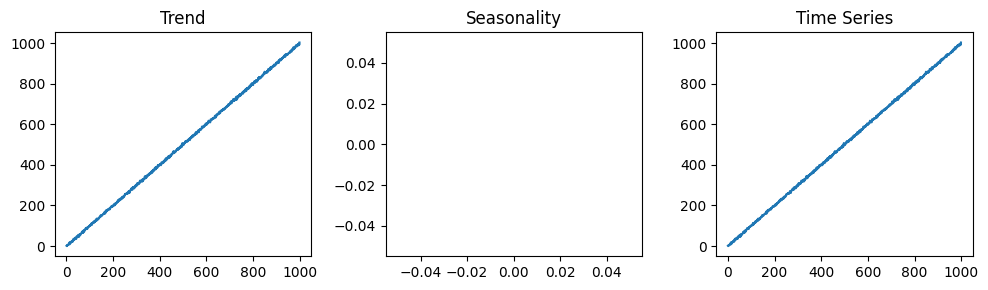

In [112]:
time_series = generate_time_series(n_steps = 1000, trend_min = 0.0, trend_max = 999.0, trend_noise_scale = 3.0, num_cycles = 0)
plot_time_series(time_series)

In [113]:
window = 10
scaler = None
differencing = True

train_dataset = TimeSeriesDataset(time_series['total'], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [114]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")

In [117]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 12.807
Epoch: 20. Train loss: 12.519
Epoch: 30. Train loss: 12.267
Epoch: 40. Train loss: 12.021
Epoch: 50. Train loss: 11.817
Epoch: 60. Train loss: 11.617
Epoch: 70. Train loss: 11.116
Epoch: 80. Train loss: 10.877
Epoch: 90. Train loss: 10.775
Epoch: 100. Train loss: 10.720


[ 1.21190882e+00 -2.86852479e-01  1.27958328e-01  3.99869132e+00
  4.46504974e+00  3.58980107e+00  5.90033197e+00  6.68669510e+00
  8.86948109e+00  7.15497541e+00  7.66495037e+00  1.38994198e+01
  1.54804401e+01  1.80488548e+01  8.90564346e+00  9.92007065e+00
  1.80309372e+01  1.93190670e+01  1.64579906e+01  1.60760307e+01
  2.18176041e+01  1.95169640e+01  2.24489670e+01  2.06984596e+01
  2.26833992e+01  2.64073715e+01  2.46945858e+01  2.16413479e+01
  2.97668800e+01  2.78256130e+01  3.57291794e+01  2.88772278e+01
  3.37114716e+01  3.31434631e+01  3.62110062e+01  3.46105614e+01
  3.30997314e+01  4.09308815e+01  3.87501144e+01  3.91783714e+01
  3.71214676e+01  4.11761818e+01  3.58225822e+01  4.62032127e+01
  4.79621048e+01  4.89888039e+01  4.65307159e+01  4.53272324e+01
  4.72494202e+01  4.89099617e+01  5.50397682e+01  5.29283142e+01
  5.21633110e+01  4.43930130e+01  5.51580505e+01  5.59392395e+01
  4.96492615e+01  5.89976387e+01  5.51610374e+01  5.71450424e+01
  5.76472473e+01  5.66529

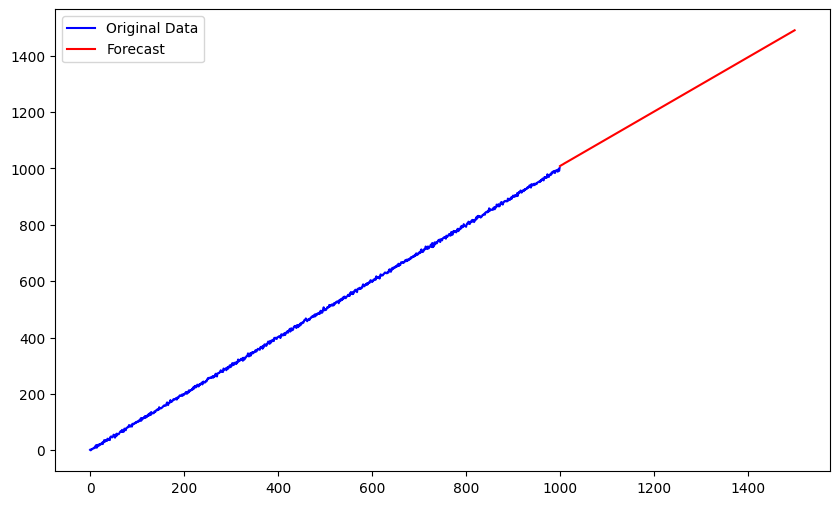

In [118]:
forecast(model, train_dataset, time_series, forecast_step = 500, differencing = differencing)